# Baseline: semantic segmentation + local explainability

Order in the numpy
["female/090042.jpg", "female/090228.jpg", "female/090779.jpg", "female/091189.jpg", "female/091708.jpg", "female/092142.jpg", "female/092176.jpg",
                   "female/092400.jpg", "female/092980.jpg", "female/093006.jpg", "male/090092.jpg", "male/090445.jpg", "male/090719.jpg", "male/090737.jpg",
                   "male/090770.jpg", "male/091069.jpg", "male/091088.jpg", "male/091130.jpg", "male/091131.jpg", "male/091428.jpg"]

In [172]:
import numpy as np
from pathlib import Path
from skimage.color import rgba2rgb
from skimage import io
import matplotlib.pyplot as plt
import time
from PIL import Image

import cv2 as cv
import mxnet as mx
import gluoncv
from gluoncv.data.transforms.presets.segmentation import test_transform
from mxnet import image
# using cpu
ctx = mx.cpu(0)

from shapely.geometry import Polygon
from shapely.ops import unary_union


In [173]:
images_npy = np.load(Path("../../../../msc_work/msc_thesis/panagiotis_soilis_19_20/pilot_study/pilot_study/images.npy"))
heatmaps_npy = np.load(Path("../../../../msc_work/msc_thesis/panagiotis_soilis_19_20/pilot_study/pilot_study/heatmaps.npy"))

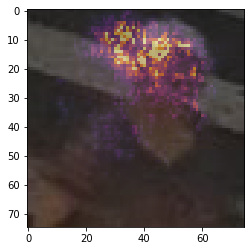

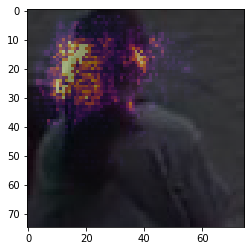

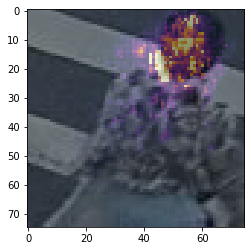

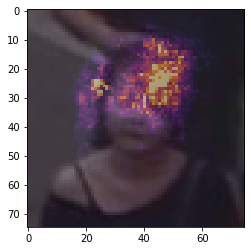

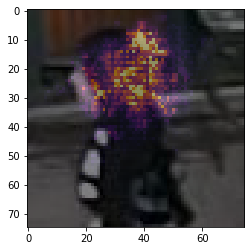

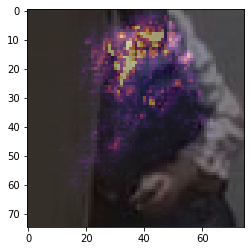

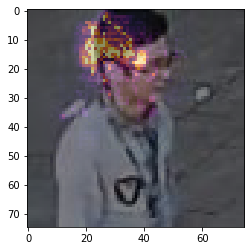

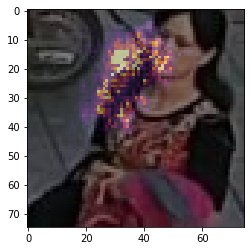

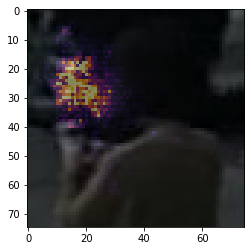

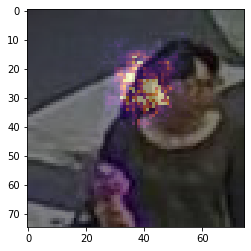

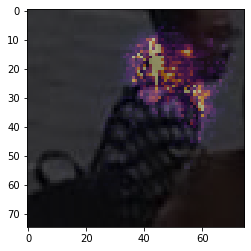

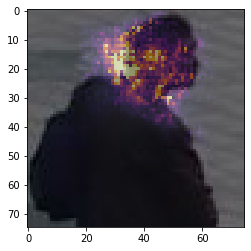

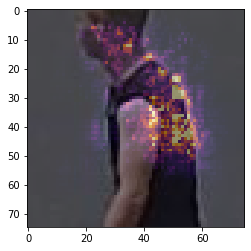

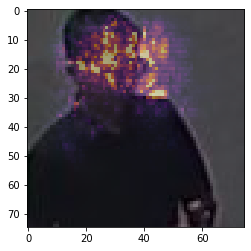

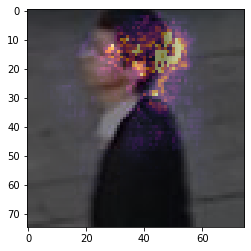

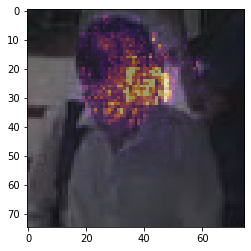

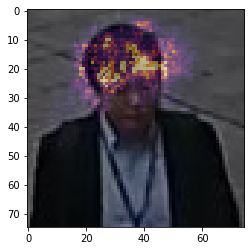

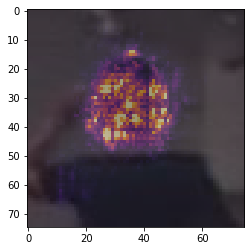

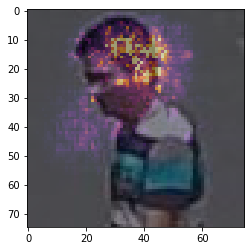

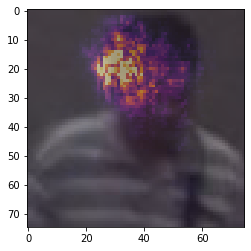

In [174]:
# Disply image overlay

for i, _ in enumerate(images_npy):
    image_overlay = 0.5 * (images_npy[i]/255) + 0.5 * rgba2rgb(heatmaps_npy[i])
    plt.imshow(image_overlay)
    plt.show()

In [175]:
def rescaleImage(image_file):
    img = image.imread(image_file)

    if (img.shape[0] > 512) and (img.shape[1] > 512):
        shapes = [img.shape[0], img.shape[1]]
        min_dim = shapes.index(min(shapes))
        max_dim = shapes.index(max(shapes))
        ratio = min(shapes) / 512
        other_shape = max(shapes)/ ratio
        new_size = [0, 0]
        new_size[min_dim] = 512
        new_size[max_dim] = int(other_shape)
        img = image.imresize(img, new_size[1], new_size[0])
    else:
        ratio = 1
    return img, ratio

def getSemanticSegmentation(img, ctx):
    img = test_transform(img, ctx)
    model = gluoncv.model_zoo.get_model('deeplab_resnet101_ade', pretrained=True)
    # Get image predictions
    output = model.predict(img)

    # Post process the prediction
    start = time.time()
    test1 = mx.nd.squeeze(mx.nd.topk(output, axis=1, ret_typ='indices')).asnumpy()
    end = time.time()
    print(end-start)
    return test1

## Get the image semantic segmentation

In [176]:
image_name = "090042"
image_file = Path("../../../../msc_work/msc_thesis/panagiotis_soilis_19_20/pilot_study/pilot_study/female/" + image_name + ".jpg")
img = image.imread(image_file)
test1 = getSemanticSegmentation(img, ctx)
print(test1.shape)

12.686116933822632
(225, 225)


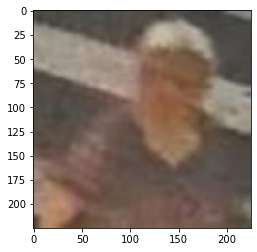

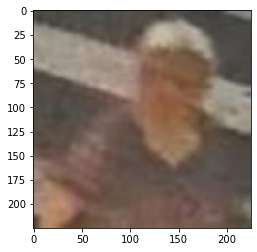

In [177]:
# Rescale image for input to semantic segmentation
image_name = "090042"
image_file = Path("../../../../msc_work/msc_thesis/panagiotis_soilis_19_20/pilot_study/pilot_study/female/" + image_name + ".jpg")
img = image.imread(image_file)
img_rescale, ratio = rescaleImage(image_file)

# Check image appearance
from matplotlib import pyplot as plt
plt.imshow(img.asnumpy())
plt.show()


plt.imshow(img_rescale.asnumpy())
plt.show()


In [178]:
# Transform the image format into an input for the semantic segmentation
print(img.shape)
img = test_transform(img, ctx)
print(img.shape)

(225, 225, 3)
(1, 3, 225, 225)


In [179]:
# Get the semantic segmentation model
model = gluoncv.model_zoo.get_model('deeplab_resnet101_ade', pretrained=True)

In [180]:
# Get image predictions
output = model.predict(img)

# Post process the prediction
start = time.time()
test1 = mx.nd.squeeze(mx.nd.topk(output, axis=1, ret_typ='indices')).asnumpy()
end = time.time()
print(end-start)
print(test1.shape)

13.225101709365845
(225, 225)


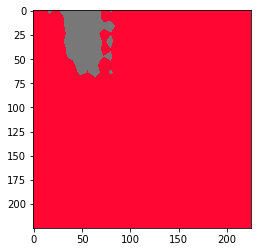

In [181]:
# Visualize the top 1 prediction classes
from gluoncv.utils.viz import get_color_pallete
import matplotlib.image as mpimg
mask = get_color_pallete(test1, 'ade20k')
mask.save('output.png')
mmask = mpimg.imread('output.png')
plt.imshow(mmask)
plt.show()

In [182]:
# We transform the semantic segmentation into a list of polygons (for the top-1 classes with their class).

def findClassName(x):
    # ADE dataset classes # numbered from 1!
    CLASSES = ("wall", "building, edifice", "sky", "floor, flooring", "tree",
               "ceiling", "road, route", "bed", "windowpane, window", "grass",
               "cabinet", "sidewalk, pavement",
               "person, individual, someone, somebody, mortal, soul",
               "earth, ground", "door, double door", "table", "mountain, mount",
               "plant, flora, plant life", "curtain, drape, drapery, mantle, pall",
               "chair", "car, auto, automobile, machine, motorcar",
               "water", "painting, picture", "sofa, couch, lounge", "shelf",
               "house", "sea", "mirror", "rug, carpet, carpeting", "field", "armchair",
               "seat", "fence, fencing", "desk", "rock, stone", "wardrobe, closet, press",
               "lamp", "bathtub, bathing tub, bath, tub", "railing, rail", "cushion",
               "base, pedestal, stand", "box", "column, pillar", "signboard, sign",
               "chest of drawers, chest, bureau, dresser", "counter", "sand", "sink",
               "skyscraper", "fireplace, hearth, open fireplace", "refrigerator, icebox",
               "grandstand, covered stand", "path", "stairs, steps", "runway",
               "case, display case, showcase, vitrine",
               "pool table, billiard table, snooker table", "pillow",
               "screen door, screen", "stairway, staircase", "river", "bridge, span",
               "bookcase", "blind, screen", "coffee table, cocktail table",
               "toilet, can, commode, crapper, pot, potty, stool, throne",
               "flower", "book", "hill", "bench", "countertop",
               "stove, kitchen stove, range, kitchen range, cooking stove",
               "palm, palm tree", "kitchen island",
               "computer, computing machine, computing device, data processor, "
               "electronic computer, information processing system",
               "swivel chair", "boat", "bar", "arcade machine",
               "hovel, hut, hutch, shack, shanty",
               "bus, autobus, coach, charabanc, double-decker, jitney, motorbus, "
               "motorcoach, omnibus, passenger vehicle",
               "towel", "light, light source", "truck, motortruck", "tower",
               "chandelier, pendant, pendent", "awning, sunshade, sunblind",
               "streetlight, street lamp", "booth, cubicle, stall, kiosk",
               "television receiver, television, television set, tv, tv set, idiot "
               "box, boob tube, telly, goggle box",
               "airplane, aeroplane, plane", "dirt track",
               "apparel, wearing apparel, dress, clothes",
               "pole", "land, ground, soil",
               "bannister, banister, balustrade, balusters, handrail",
               "escalator, moving staircase, moving stairway",
               "ottoman, pouf, pouffe, puff, hassock",
               "bottle", "buffet, counter, sideboard",
               "poster, posting, placard, notice, bill, card",
               "stage", "van", "ship", "fountain",
               "conveyer belt, conveyor belt, conveyer, conveyor, transporter",
               "canopy", "washer, automatic washer, washing machine",
               "plaything, toy", "swimming pool, swimming bath, natatorium",
               "stool", "barrel, cask", "basket, handbasket", "waterfall, falls",
               "tent, collapsible shelter", "bag", "minibike, motorbike", "cradle",
               "oven", "ball", "food, solid food", "step, stair", "tank, storage tank",
               "trade name, brand name, brand, marque", "microwave, microwave oven",
               "pot, flowerpot", "animal, animate being, beast, brute, creature, fauna",
               "bicycle, bike, wheel, cycle", "lake",
               "dishwasher, dish washer, dishwashing machine",
               "screen, silver screen, projection screen",
               "blanket, cover", "sculpture", "hood, exhaust hood", "sconce", "vase",
               "traffic light, traffic signal, stoplight", "tray",
               "ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, "
               "dustbin, trash barrel, trash bin",
               "fan", "pier, wharf, wharfage, dock", "crt screen",
               "plate", "monitor, monitoring device", "bulletin board, notice board",
               "shower", "radiator", "glass, drinking glass", "clock", "flag")
    return CLASSES[x]


def createMaskSegments(prediction):
    # Get unique possible values
    unique_val = np.unique(prediction)
    list_masks_dec = []
    list_masks_rgb = []
    list_class = []
    for x in np.nditer(unique_val):
        list_class.append(findClassName(int(x)))
        #new_mask = np.zeros((prediction.shape[0], prediction.shape[1], 3))
        # Where we find the value, we set it to 1 to become white.
        #idx_mask = np.where(prediction == x)
        masked_im_dec = (np.where(prediction == x, 0.99, 0))
        masked_im_rgb = (np.where(prediction == x, 255, 0))
        #print(masked_im)
        new_mask_dec = np.repeat(masked_im_dec[:, :, np.newaxis], 3, axis=2) # np.expand_dims(masked_im, axis=2)
        new_mask_rgb = np.repeat(masked_im_rgb[:, :, np.newaxis], 3, axis=2)
        #print(new_mask)
        list_masks_dec.append(new_mask_dec)
        list_masks_rgb.append(new_mask_rgb)
    return list_masks_dec, list_masks_rgb, list_class

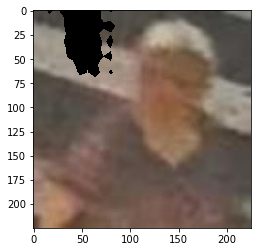

In [183]:
visualize_identified_class_nb = 0

new_im_dec, new_im_rgb, list_class = (createMaskSegments(test1))
new_im1 = Image.fromarray(new_im_rgb[visualize_identified_class_nb].astype('uint8'))
new_im1.save('test_mask_output.png')
new_im1_cv = cv.cvtColor(np.array(new_im1), cv.COLOR_RGB2BGR)
imgray = cv.cvtColor(new_im1_cv, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
resized_contour = ([(x*ratio).astype(int) for x in contours])

resized_image_process = img_rescale.asnumpy()
cv.drawContours(resized_image_process, resized_contour, -1, (0,0,0), thickness=cv.FILLED)
plt.imshow(resized_image_process)
plt.show()

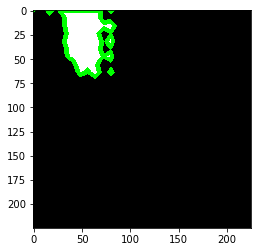

In [184]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
from matplotlib import pyplot as plt
plt.imshow(thresh)

cv.drawContours(new_im1_cv, contours, -1, (0,255,0), 3)

plt.imshow( new_im1_cv)
plt.show()

In [185]:
def contourToPolygon(output_contours):
    list_polygon = []
    for contour in output_contours:
        contour = np.squeeze(contour)
        if len(contour) > 2:
            list_polygon.append(Polygon(contour))
    return list_polygon

def deeplabPredToOutput(prediction, _plot=False):
    new_im_dec, new_im_rgb, list_class = (createMaskSegments(prediction))
    
    list_polygons = []
    for mask, class_name in zip(new_im_rgb, list_class):
        new_im1 = Image.fromarray(mask.astype('uint8'))
        new_im1_cv = cv.cvtColor(np.array(new_im1), cv.COLOR_RGB2BGR)
        imgray = cv.cvtColor(new_im1_cv, cv.COLOR_BGR2GRAY)
        ret, thresh = cv.threshold(imgray, 127, 255, 0)
        contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

        if _plot:
            plt.imshow(thresh)
            cv.drawContours(new_im1_cv, contours, -1, (0,255,0), 3)
            plt.imshow( new_im1_cv)
            plt.show()

        list_polygons.append((contourToPolygon(contours), class_name))
    
    return list_polygons

In [186]:
list_polygons = deeplabPredToOutput(test1)

# Merge polygons which might be overlapping

def cleanPolygons(list_polygon):
    if len(list_polygon) > 1:
        merged_poly = (unary_union(list_polygon))
        if merged_poly.geom_type == 'MultiPolygon':
            merged_poly = list(merged_poly)
    else:
        merged_poly = class_poly
    return merged_poly
    
    
clean_list_polygons_segments = []
for class_poly in list_polygons:
    merged_poly = cleanPolygons(class_poly[0])
    clean_list_polygons_segments.append((merged_poly, class_poly[1]))
    
"""
    if len(class_poly[0]) > 1:
        merged_poly = (unary_union(class_poly[0]))
        if merged_poly.geom_type == 'MultiPolygon':
            merged_poly = list(merged_poly)
    else:
        merged_poly = class_poly
"""
    

"\n    if len(class_poly[0]) > 1:\n        merged_poly = (unary_union(class_poly[0]))\n        if merged_poly.geom_type == 'MultiPolygon':\n            merged_poly = list(merged_poly)\n    else:\n        merged_poly = class_poly\n"

In [187]:
print(list_polygons)
print(clean_list_polygons)

[([<shapely.geometry.polygon.Polygon object at 0x000001DF0A9DB148>, <shapely.geometry.polygon.Polygon object at 0x000001DF0A9DBF48>, <shapely.geometry.polygon.Polygon object at 0x000001DF0A9DB948>, <shapely.geometry.polygon.Polygon object at 0x000001DF0A9DB8C8>, <shapely.geometry.polygon.Polygon object at 0x000001DF0A9DB348>], 'wall'), ([<shapely.geometry.polygon.Polygon object at 0x000001DF0A9DB4C8>, <shapely.geometry.polygon.Polygon object at 0x000001DF0A9DBA88>, <shapely.geometry.polygon.Polygon object at 0x000001DF0A9DBC08>], 'painting, picture')]
[]


## Transform the heatmaps into lists of polygons

In [188]:
# We transform the heatmaps into a list of polygons... (later we could maybe look at their numerical confidence).
from PIL import Image

# Get the grayscale heatmap.
type_image = "female/"
gray_heatmap_path = Path("../../../../msc_work/msc_thesis/panagiotis_soilis_19_20/raw_smoothgrad_heatmaps/raw_smoothgrad_heatmaps/" \
                         + type_image + image_name  + "_raw_heatmap.jpg")
image_gray = io.imread(gray_heatmap_path, as_gray=True)

new_size = test1.shape
from skimage.transform import resize
image_gray = resize(image_gray, new_size)


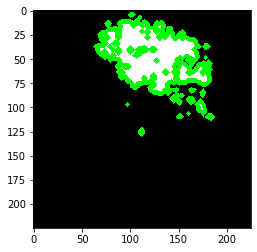

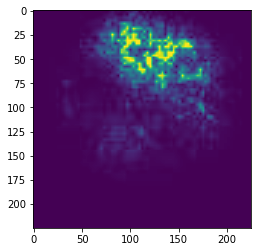

In [189]:
threshold_heatmap = 0.2 ### We need to think a bit more on how to fix this threshold....
_plot = True
masked_im_rgb = (np.where(image_gray > threshold_heatmap, 255, 0))
grey_mask = np.repeat(masked_im_rgb[:, :, np.newaxis], 3, axis=2)
new_im1 = Image.fromarray(grey_mask.astype('uint8'))
new_im1_cv = cv.cvtColor(np.array(new_im1), cv.COLOR_RGB2BGR)
imgray = cv.cvtColor(new_im1_cv, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

if _plot:
    plt.imshow(thresh)
    cv.drawContours(new_im1_cv, contours, -1, (0,255,0), 3)
    plt.imshow( new_im1_cv)
    plt.show()
    plt.imshow(image_gray)
    plt.show()
    
list_polygon = contourToPolygon(contours)
clean_list_polygon_heatmap = cleanPolygons(list_polygon)

In [191]:
from skimage.transform import resize
    # threshold_heatmap = 0.2 ### We need to think a bit more on how to fix this threshold....

def getHeatmapPolygons(gray_heatmap_path, new_size, threshold_heatmap = 0.2):
    image_gray = io.imread(gray_heatmap_path, as_gray=True)
    image_gray = resize(image_gray, new_size)
    _plot = True
    masked_im_rgb = (np.where(image_gray > threshold_heatmap, 255, 0))
    grey_mask = np.repeat(masked_im_rgb[:, :, np.newaxis], 3, axis=2)
    new_im1 = Image.fromarray(grey_mask.astype('uint8'))
    new_im1_cv = cv.cvtColor(np.array(new_im1), cv.COLOR_RGB2BGR)
    imgray = cv.cvtColor(new_im1_cv, cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(imgray, 127, 255, 0)
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    list_polygon = contourToPolygon(contours)
    clean_list_polygon_heatmap = cleanPolygons(list_polygon)
    return clean_list_polygon_heatmap

clean_list_polygon_heatmap = getHeatmapPolygons(gray_heatmap_path, test1.shape, threshold_heatmap)

## Map the heatmaps to the semantic segmentation to get labels

In [192]:
# We compute the intersection. If heatmap within the class or only X % outside, then we atttribute it the class.

# We go through each polygon of the heatmap and find to which classes it;s associated. -> we could also get numerical features later, but is it useful?

def checkIntersectionRelevance(list_intersections, intersection_threshold):
    if not isinstance(list_intersections, list):
        list_intersections = [list_intersections]
        
    for intersection_poly in list_intersections:
        if intersection_poly.area > intersection_threshold:
            return True
    return False
    
def getLabelMapping(clean_list_polygon_heatmap, clean_list_polygons_segments, intersection_threshold = 0.0):
     # area of intersection: intersection_threshold
    list_outputs = []
    for poly in clean_list_polygon_heatmap:
        # Compute the intersection with each segment.
        for class_segment in clean_list_polygons_segments:
            class_name = class_segment[1]
            if isinstance(class_segment[0], list):
                for segment in class_segment[0]:
                    list_intersections = poly.intersection(segment)
                    if checkIntersectionRelevance(list_intersections, intersection_threshold):
                        list_outputs.append(class_name)
                        break  
            else:
                list_intersections = poly.intersection(class_segment[0])
                if checkIntersectionRelevance(list_intersections, intersection_threshold):
                        list_outputs.append(class_name)
    return list_outputs

list_outputs = getLabelMapping(clean_list_polygon_heatmap, clean_list_polygons_segments, intersection_threshold)
# Do we want to post-process the outputs to obtain only unique classes?
        

## Whole pipeline

In [193]:
def getImageLabels(image_file, heatmap_file, threshold_heatmap=0.2, intersection_threshold=0.0):
    img = image.imread(image_file)
    
    # Semantic segmentation output.
    test1 = getSemanticSegmentation(img, ctx)
    list_polygons = deeplabPredToOutput(test1)
    clean_list_polygons_segments = []
    for class_poly in list_polygons:
        merged_poly = cleanPolygons(class_poly[0])
        clean_list_polygons_segments.append((merged_poly, class_poly[1]))
        
    # Heatmap polygons.
    clean_list_polygon_heatmap = getHeatmapPolygons(gray_heatmap_path, test1.shape, threshold_heatmap)
    
    # Get the mapping.
    list_outputs = getLabelMapping(clean_list_polygon_heatmap, clean_list_polygons_segments, intersection_threshold)
    return list_outputs

image_name = "090042"
type_image = "female/"
image_file = Path("../../../../msc_work/msc_thesis/panagiotis_soilis_19_20/pilot_study/pilot_study/" + type_image + image_name + ".jpg")

gray_heatmap_path = Path("../../../../msc_work/msc_thesis/panagiotis_soilis_19_20/raw_smoothgrad_heatmaps/raw_smoothgrad_heatmaps/" \
                         + type_image + image_name  + "_raw_heatmap.jpg")

list_labels = getImageLabels(image_file, gray_heatmap_path, threshold_heatmap=0.2, intersection_threshold=0.0)

# If you want only unique labels.
list_labels_unique = list(set(list_labels))

16.909595489501953


In [194]:
list_labels_unique

['painting, picture', 'wall']